<a href="https://colab.research.google.com/github/ben45123/AWS-Lambda-Research/blob/main/ComputerVisionFinalProject/SkinType.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Import Required Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import shutil

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


Path to dataset files: /kaggle/input/oily-dry-and-normal-skin-types-dataset
Contents of the dataset directory:
['Oily-Dry-Skin-Types']
Contents of Oily-Dry-Skin-Types directory: ['README.dataset.txt', 'valid', 'test', 'train']
Found directories - Train: True, Test: True, Validation: True
Train subdirectories: ['dry', 'normal', 'oily']
  dry: 652 images
  normal: 1104 images
  oily: 1000 images
Validation subdirectories: ['dry', 'normal', 'oily']
  dry: 71 images
  normal: 111 images
  oily: 80 images
Test subdirectories: ['dry', 'normal', 'oily']
  dry: 35 images
  normal: 59 images
  oily: 40 images


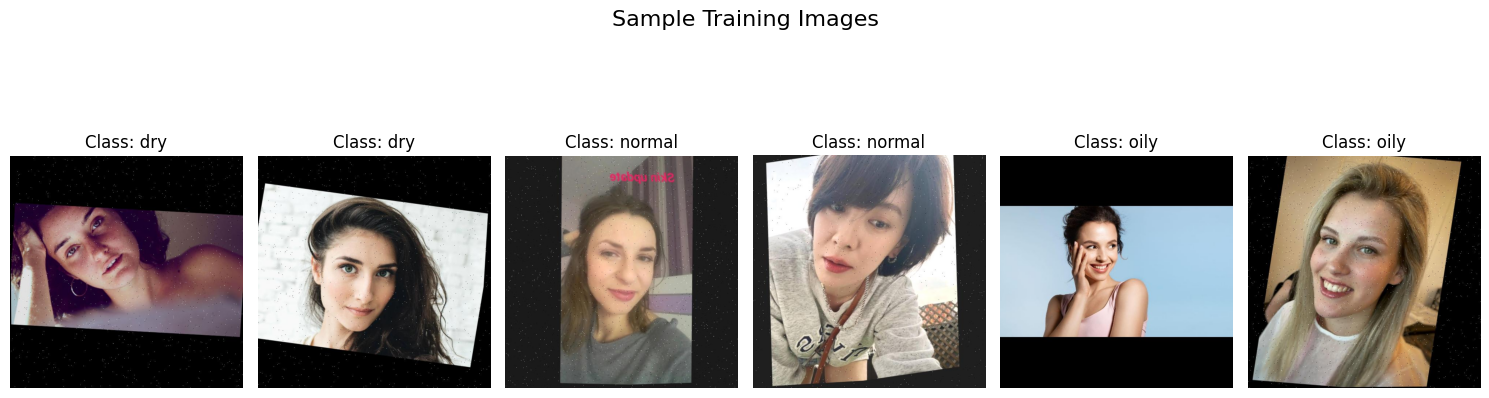

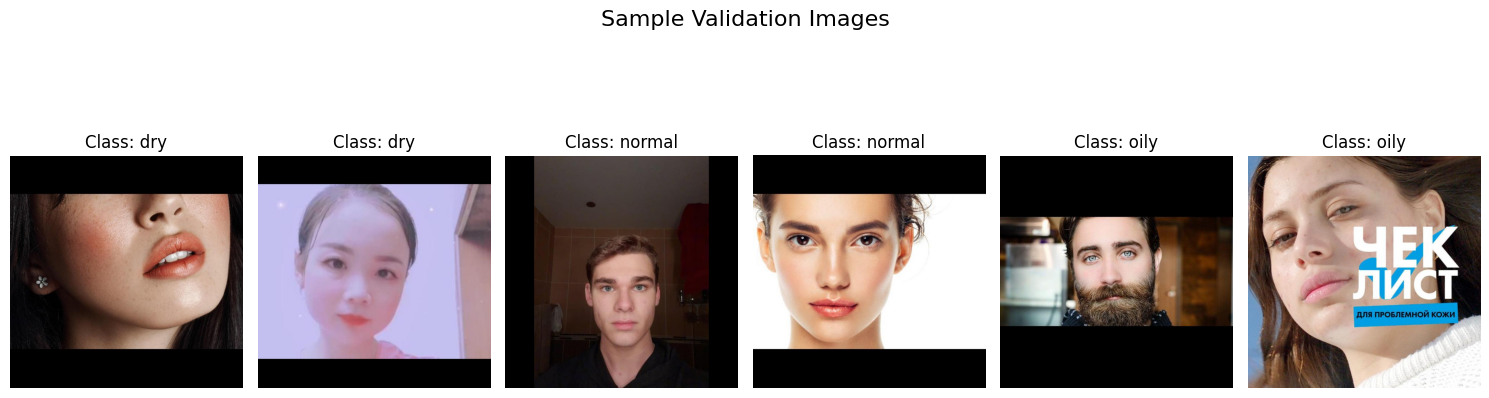

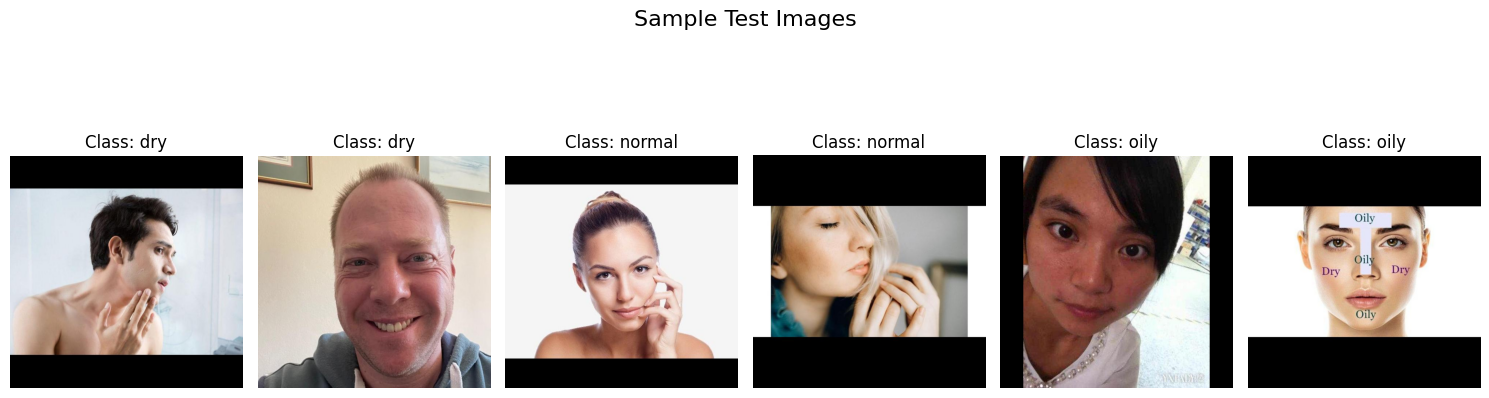

In [9]:
# Cell 2: Set Configuration Parameters for Skin Type Model
import kagglehub
import os
import matplotlib.pyplot as plt
import cv2
import random

# Download dataset
path = kagglehub.dataset_download("shakyadissanayake/oily-dry-and-normal-skin-types-dataset")
print("Path to dataset files:", path)

# Let's examine the directory structure
print("Contents of the dataset directory:")
dataset_contents = os.listdir(path)
print(dataset_contents)

# We have an additional level of nesting
data_dir = os.path.join(path, "Oily-Dry-Skin-Types")
if os.path.exists(data_dir):
    nested_contents = os.listdir(data_dir)
    print(f"Contents of Oily-Dry-Skin-Types directory: {nested_contents}")

    # Now check for train, test, valid
    train_dir = os.path.join(data_dir, "train")
    test_dir = os.path.join(data_dir, "test")
    valid_dir = os.path.join(data_dir, "valid")  # Dataset might use 'valid' instead of 'validation'

    # Check if these directories exist
    train_exists = os.path.exists(train_dir)
    test_exists = os.path.exists(test_dir)
    valid_exists = os.path.exists(valid_dir)

    print(f"Found directories - Train: {train_exists}, Test: {test_exists}, Validation: {valid_exists}")

    # Check contents of each directory
    if train_exists:
        train_subdirs = os.listdir(train_dir)
        print(f"Train subdirectories: {train_subdirs}")
        for subdir in train_subdirs:
            subdir_path = os.path.join(train_dir, subdir)
            if os.path.isdir(subdir_path):
                count = len([f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')])
                print(f"  {subdir}: {count} images")

    if valid_exists:
        valid_subdirs = os.listdir(valid_dir)
        print(f"Validation subdirectories: {valid_subdirs}")
        for subdir in valid_subdirs:
            subdir_path = os.path.join(valid_dir, subdir)
            if os.path.isdir(subdir_path):
                count = len([f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')])
                print(f"  {subdir}: {count} images")

    if test_exists:
        test_subdirs = os.listdir(test_dir)
        print(f"Test subdirectories: {test_subdirs}")
        for subdir in test_subdirs:
            subdir_path = os.path.join(test_dir, subdir)
            if os.path.isdir(subdir_path):
                count = len([f for f in os.listdir(subdir_path) if f.lower().endswith('.jpg')])
                print(f"  {subdir}: {count} images")

    # Configuration
    IMG_SIZE = 224  # Standard input size for MobileNetV2
    BATCH_SIZE = 32
    EPOCHS = 15
    NUM_CLASSES = 3  # Oily, Dry, Normal
    CLASS_NAMES = ['Dry', 'Normal', 'Oily']  # Using capitalized version for consistency

    # Set paths to use the existing directory structure
    TRAIN_DIR = train_dir if train_exists else None
    VAL_DIR = valid_dir if valid_exists else None
    TEST_DIR = test_dir if test_exists else None

    # Create output directory for saving model checkpoints
    OUTPUT_DIR = "./models/skin_type/"
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    # Display sample images from each set
    def display_sample_images(directory, title, samples_per_class=2):
        """Display sample images from the dataset directory structure"""
        if directory is None:
            print(f"Cannot display {title} - directory not found")
            return

        plt.figure(figsize=(15, 5))
        plt.suptitle(title, fontsize=16)

        all_samples = []

        # Get sample images from each class
        for i, class_name in enumerate(['dry', 'normal', 'oily']):
            class_dir = os.path.join(directory, class_name)
            if os.path.exists(class_dir):
                images = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
                if images:
                    samples = random.sample(images, min(samples_per_class, len(images)))
                    for sample in samples:
                        img_path = os.path.join(class_dir, sample)
                        all_samples.append((img_path, class_name))

        # Display up to 6 images
        for i, (img_path, class_name) in enumerate(all_samples[:6]):
            plt.subplot(1, 6, i+1)
            try:
                img = cv2.imread(img_path)
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img_rgb)
                plt.title(f'Class: {class_name}')
                plt.axis('off')
            except Exception as e:
                print(f"Error displaying image {img_path}: {e}")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    # Sample a few images from each split
    try:
        if TRAIN_DIR:
            display_sample_images(TRAIN_DIR, 'Sample Training Images')
        if VAL_DIR:
            display_sample_images(VAL_DIR, 'Sample Validation Images')
        if TEST_DIR:
            display_sample_images(TEST_DIR, 'Sample Test Images')
    except Exception as e:
        print(f"Error displaying sample images: {e}")
else:
    print("Oily-Dry-Skin-Types directory not found. Please check the dataset structure.")

In [10]:
# Cell 3: Set Up Data Generators with Augmentation
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation and testing, we only rescale
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators - using lowercase class names to match the directory structure
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Get class indices and print them
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Update CLASS_NAMES based on actual class indices
CLASS_NAMES = list(class_indices.keys())
print("Class names from generator:", CLASS_NAMES)

Found 2756 images belonging to 3 classes.
Found 262 images belonging to 3 classes.
Found 134 images belonging to 3 classes.
Class indices: {'dry': 0, 'normal': 1, 'oily': 2}
Class names from generator: ['dry', 'normal', 'oily']


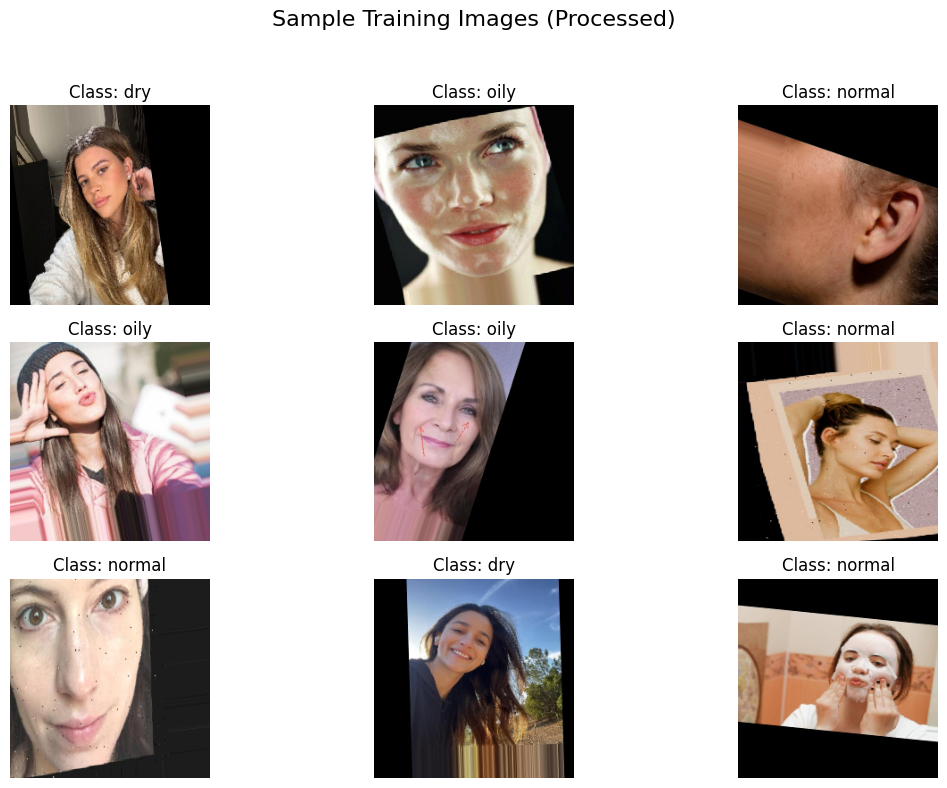

In [11]:
# Cell 4: Visualize Sample Images from the Data Generator
import numpy as np

def display_sample_images_from_generator(generator, title):
    """
    Display sample images from a data generator.

    Args:
        generator: Data generator
        title: Title for the plot
    """
    # Get a batch of images
    x_batch, y_batch = next(generator)

    # Create a figure
    plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)

    # Display up to 9 images from the batch
    for i in range(min(9, len(x_batch))):
        plt.subplot(3, 3, i+1)
        plt.imshow(x_batch[i])
        class_idx = np.argmax(y_batch[i])
        class_name = list(class_indices.keys())[class_idx]
        plt.title(f'Class: {class_name}')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Display sample images from training set
display_sample_images_from_generator(train_generator, 'Sample Training Images (Processed)')

In [12]:
# Cell 5: Define Preprocessing Functions
def detect_face(image):
    """
    Detect face in an image and return the face region.

    Args:
        image: Input image (BGR format from OpenCV)

    Returns:
        Face region if found, otherwise the original image
    """
    # Load pre-trained face detector from OpenCV
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If faces are found, return the first face region
    if len(faces) > 0:
        x, y, w, h = faces[0]
        face_region = image[y:y+h, x:x+w]
        return face_region
    else:
        # If no face is detected, return the original image
        return image

def preprocess_image(image_path, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    Load image, detect face, and preprocess for model input.

    Args:
        image_path: Path to the image file
        target_size: Target size for model input

    Returns:
        Preprocessed image ready for model input
    """
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}")

    # Detect face
    face = detect_face(image)

    # Resize to target size
    face_resized = cv2.resize(face, target_size)

    # Convert BGR to RGB (TensorFlow uses RGB)
    face_rgb = cv2.cvtColor(face_resized, cv2.COLOR_BGR2RGB)

    # Normalize pixel values to [0, 1]
    face_normalized = face_rgb / 255.0

    return face_normalized

In [13]:
# Cell 6: Build the Skin Type Classification Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2

def build_model(num_classes=NUM_CLASSES):
    """
    Build and compile the skin type classification model.

    Args:
        num_classes: Number of output classes

    Returns:
        Compiled model
    """
    # Load MobileNetV2 as base model (without top layers)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Add dropout to prevent overfitting
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Build the model
skin_type_model = build_model()

# Print model summary
skin_type_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# Cell 7: Set Up Callbacks for Training
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_path = os.path.join(OUTPUT_DIR, "skin_type_model_best.h5")
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

callbacks = [checkpoint_callback, early_stopping]

In [15]:
# Cell 8: Train the Model
# Calculate steps per epoch and validation steps
steps_per_epoch = len(train_generator)
validation_steps = len(validation_generator)

# Train the model
history = skin_type_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3824 - loss: 1.2532
Epoch 1: val_accuracy improved from -inf to 0.41221, saving model to ./models/skin_type/skin_type_model_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.3826 - loss: 1.2519 - val_accuracy: 0.4122 - val_loss: 1.0729
Epoch 2/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4429 - loss: 1.0470
Epoch 2: val_accuracy improved from 0.41221 to 0.45420, saving model to ./models/skin_type/skin_type_model_best.h5


87/87 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.4430 - loss: 1.0470 - val_accuracy: 0.4542 - val_loss: 1.0682
Epoch 3/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4685 - loss: 1.0355
Epoch 3: val_accuracy did not improve from 0.45420
87/87 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.4686 - loss: 1.0355 - val_accuracy: 0.3931 - val_loss: 1.0865
Epoch 4/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4663 - loss: 1.0146
Epoch 4: val_accuracy did not improve from 0.45420
87/87 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.4664 - loss: 1.0146 - val_accuracy: 0.4427 - val_loss: 1.0776
Epoch 5/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5056 - loss: 0.9833
Epoch 5: val_accuracy did not improve from 0.45420
87/87 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5054 - loss: 0.9833 - val_accuracy: 0.4351 - val_loss: 1.0759
Epoch 6/15
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5178 - loss: 0.9806
Epoch 6: val_accuracy did not improve from 0.45420


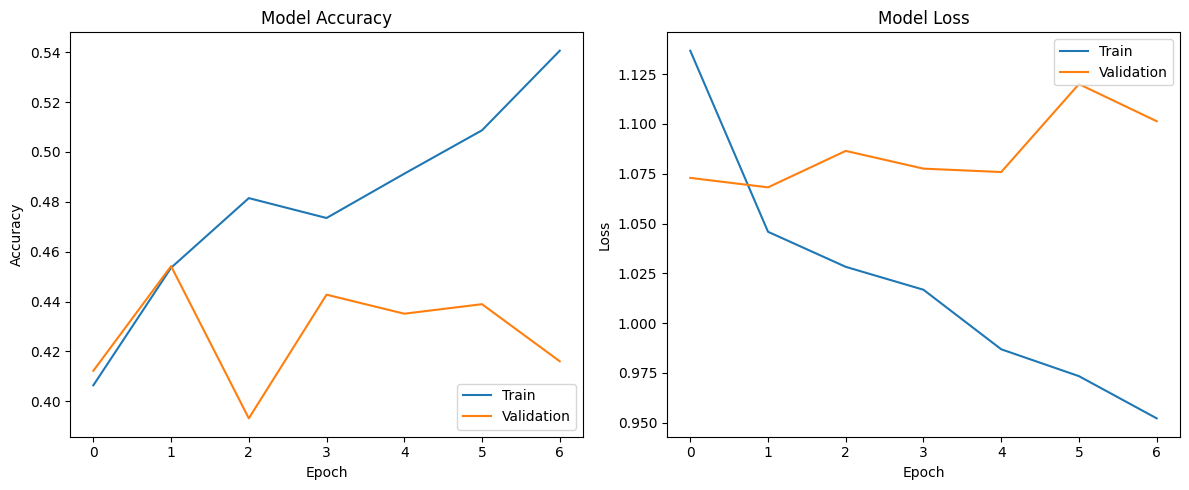

In [16]:
# Cell 9: Visualize Training History
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [17]:
# Cell 10: Evaluate Model on Test Data
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate the model on test data
test_loss, test_accuracy = skin_type_model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions for test data
test_generator.reset()
y_pred_probs = skin_type_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_probs, axis=1)

# Get true labels
y_true = test_generator.classes

# Generate classification report
class_labels = list(class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:")
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4045 - loss: 1.1053
Test Loss: 1.0350
Test Accuracy: 0.4701
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step

Classification Report:
              precision    recall  f1-score   support

         dry       0.40      0.11      0.18        35
      normal       0.47      0.76      0.58        59
        oily       0.50      0.35      0.41        40

    accuracy                           0.47       134
   macro avg       0.46      0.41      0.39       134
weighted avg       0.46      0.47      0.43       134



In [ ]:
# Cell 11: Plot Confusion Matrix
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [ ]:
# Cell 12: Save the Final Model
# Save the model
final_model_path = os.path.join(OUTPUT_DIR, "skin_type_model_final.h5")
skin_type_model.save(final_model_path)
print(f"Model saved to {final_model_path}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


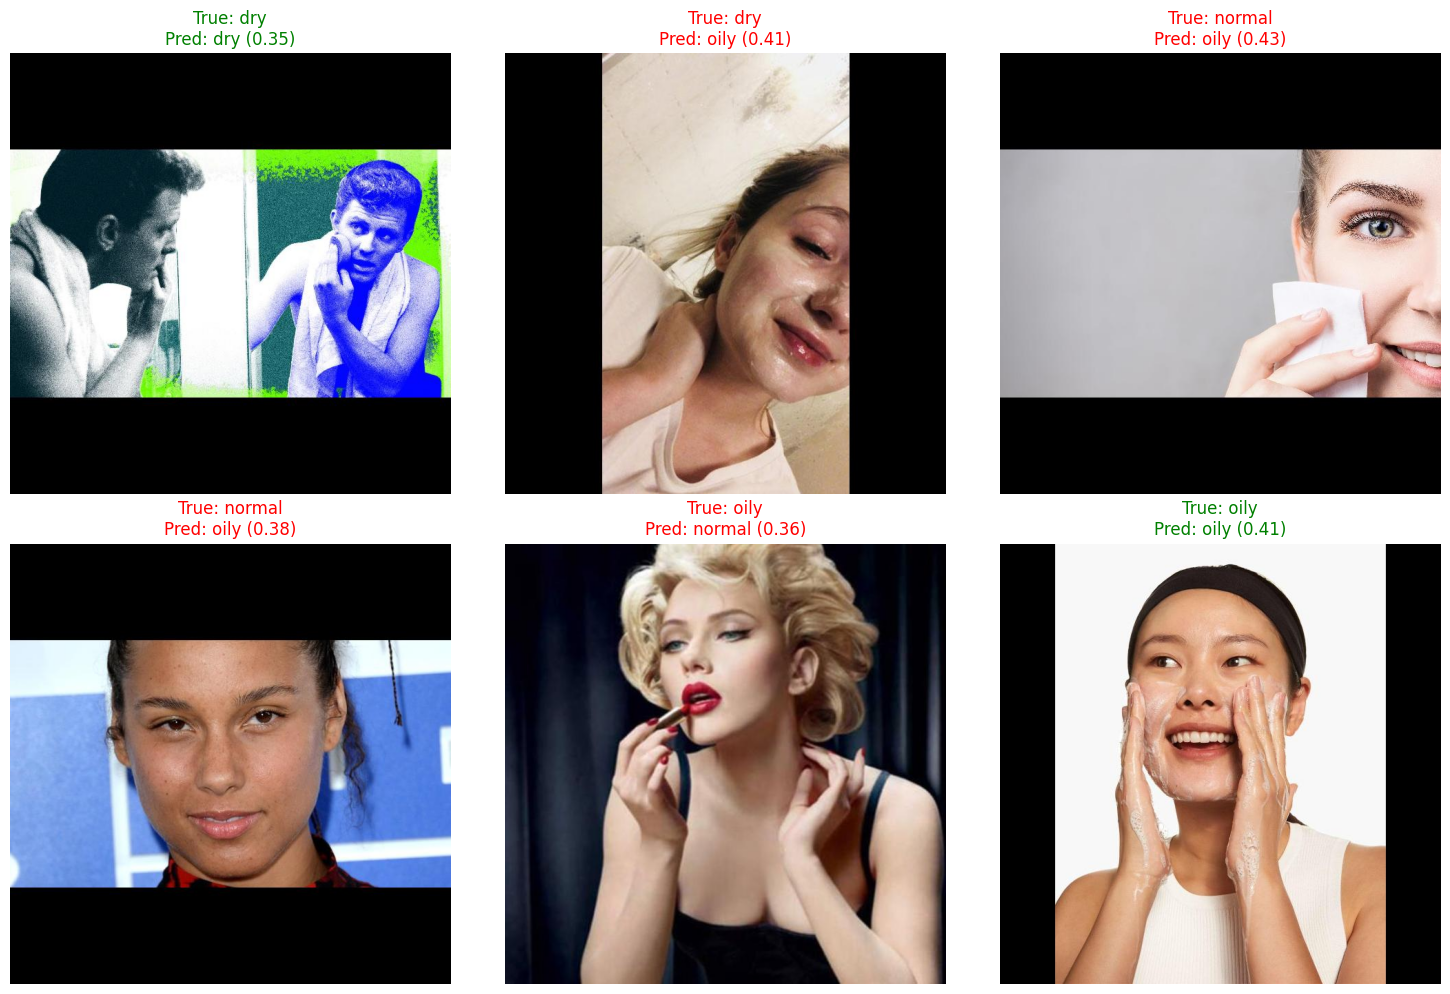

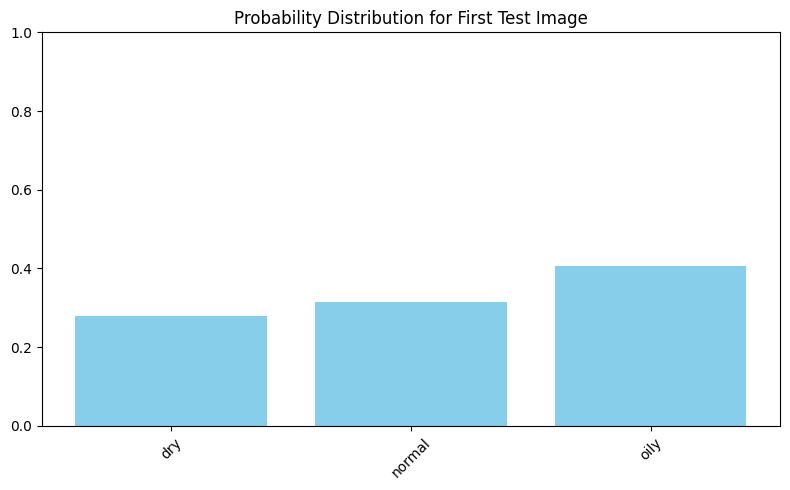

In [20]:
# Cell 13: Test with Custom Images
def predict_skin_type(image_path):
    """
    Predict skin type for a given image.

    Args:
        image_path: Path to the image file

    Returns:
        Predicted class and probability
    """
    # Preprocess the image
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Make prediction
    prediction = skin_type_model.predict(img)[0]

    # Get the predicted class and probability
    predicted_class_idx = np.argmax(prediction)
    predicted_class = list(class_indices.keys())[predicted_class_idx]
    probability = prediction[predicted_class_idx]

    return predicted_class, probability, prediction

# Select a few random test images from different classes
import random

test_images = []
for class_name in class_indices.keys():
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_dir):
        class_images = [f for f in os.listdir(class_dir) if f.lower().endswith('.jpg')]
        # Select random images from each class
        if len(class_images) > 0:
            selected = random.sample(class_images, min(2, len(class_images)))
            for img in selected:
                test_images.append(os.path.join(class_dir, img))

# Display predictions for test images
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(test_images):
    if i >= 6:  # Limit to 6 images for display clarity
        break

    # Make prediction
    predicted_class, probability, all_probs = predict_skin_type(img_path)

    # Load and display image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get true class from the path
    true_class = os.path.basename(os.path.dirname(img_path))

    # Create subplot
    plt.subplot(2, 3, i+1)
    plt.imshow(img_rgb)

    # Color the title based on prediction correctness
    color = 'green' if predicted_class == true_class else 'red'

    # Add title with prediction info
    plt.title(f'True: {true_class}\nPred: {predicted_class} ({probability:.2f})',
              color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Show probability distribution for the first image
plt.figure(figsize=(8, 5))
plt.bar(range(len(CLASS_NAMES)), all_probs, color='skyblue')
plt.xticks(range(len(CLASS_NAMES)), CLASS_NAMES, rotation=45)
plt.ylim([0, 1])
plt.title('Probability Distribution for First Test Image')
plt.tight_layout()
plt.show()